In [72]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 14 12:00:37 2020

@author: Maria_Ml
"""

import pandas as pd
import datetime 
from pandas import read_csv
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.utils import diff
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import logsumexp

In [73]:
# Germany
seriesPrice = read_csv('europrices.csv', header=0,sep=";")
seriesPower = read_csv('pvgermany.csv', header=0,sep=",")


# index 1 to 366 - 2012 
# 367 to 731 - 2013
# 732 to 1096 -2014
# 1097 to 1461 - 2015
# 1462 to 1827 - 2016
# 1828 to 2192 - 2017
# 2193 to 2557 - 2018
# 2558 to 2922 - 2019
# 2923 to 3988 - 2020

In [59]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import warnings

def tovec(row,series,comp):
    x=[]
    for i in range(comp,24+comp):
        numstr=series.iloc[row,i]
        if type(numstr) is str:
            numstr=numstr.replace("’",'')
        x.append(float(numstr))
    return np.array(x)

def tovec_single_column(row,series,column):
    x=[]
    numstr=series.iloc[row,column]
    if type(numstr) is str:
        numstr=numstr.replace("’",'')
    x.append(float(numstr))
    return np.array(x)

C:\Users\Maria\AppData\Local\Temp\ipykernel_29144\467675854.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [74]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, factor,future, arima_order):
    # prepare training dataset, factor 0.2 defines the training set
    train_size = int(len(X) * factor)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)+future):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        #history.append(test[t])
        history.append(yhat)
    # calculate out of sample error
    error = mean_squared_error(test, predictions[0:len(test)])
    return error,predictions

# evaluate an ARIMA model for a given order (p,d,q) and plots the prediction versus test data
def prediction_plot(X,factor,future,arima_order):

    #define the size of data used for model training through some length scaling parameter
    size = int(len(X) * factor)
    
    #model is trained on data in train and the test is used to compare the prediction with observed data
    train, test = X[0:size], X[size:len(X)]
    
    error, predictions = evaluate_arima_model(X,factor,future,arima_order)
    # plot test data
    pyplot.plot(test)
    # plot predicted data by the model
    pyplot.plot(predictions, color='red')
    pyplot.show()
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset,factor, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse,predictions = evaluate_arima_model(dataset,factor,0,order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg


K=seriesPower.fillna(0)
h=seriesPrice.fillna(0)

# index 1 to 366 - 2012 
# 367 to 731 - 2013
# 732 to 1096 -2014
# 1097 to 1461 - 2015
# 1462 to 1827 - 2016
# 1828 to 2192 - 2017
# 2193 to 2557 - 2018
# 2558 to 2922 - 2019
# 2923 to 3288 - 2020
            

UR=[]
VF=[]

numDays=356
twoyears=712

treeyears=1664

PowerVec = np.array([])
PriceVec = np.array([])
PowerVecH = np.array([])
PriceVecH = np.array([])
#Approximately 3 years


# Here 650 is necessarily because in the data the last 650 data cells were 0

time_chosen = np.min([len(h),len(K)])-650
for i in range(time_chosen):
    vecPower = np.zeros(24)
    #For new data
    #Note that the shift 2 used for new data since the first two columns are Country and Date
    vecPrice=tovec(i,h,1)
    #vecPower=tovec(i,K,1)
    #vecDemand=tovec(i,f,1)
    for j in range(0,24):
        vecPower[j] = tovec_single_column(24*i+j,K,2)
   # UR.append(np.sum(np.multiply(vecPrice,vecPower))/np.sum(vecPower)) 
   # VF.append(np.sum(np.multiply(vecPrice,vecPower))/(np.sum(vecPower)/np.mean(vecPrice)))
    UR.append(logsumexp(np.multiply(vecPrice,vecPower))/logsumexp(vecPower))
    VF.append (logsumexp(np.multiply(vecPrice,vecPower))/(logsumexp(vecPower)/np.mean(vecPrice)))
    
    PowerVec = np.append(PowerVec,np.sum(vecPower))
    PriceVec = np.append(PriceVec,np.mean(vecPrice))
    PowerVecH = np.append(PowerVecH,vecPower)
    PriceVecH = np.append(PriceVecH,vecPrice)

#years_num = range(2012,2021)
#ind_years = [0,365,730,1095,1460,1826,2191,2556,2921,3287]

years_num = range(2012,2019)
ind_years = [0,365,730,1095,1460,1826,2191,2556]

Days = np.arange(0,len(PowerVec)-0.5)
PowerVecYears = np.zeros(len(ind_years)-1)
for i in range(len(ind_years)-1):
    PowerVecYears[i] = np.sum(PowerVec[ind_years[i]:ind_years[i+1]])
    
URvec=np.array(UR)
VFvec=np.array(VF)


URdataframe=pd.DataFrame(URvec,columns=['Ur'])
VFdataframe=pd.DataFrame(VFvec,columns=['VF'])          

URvec=np.array(UR)
VFvec=np.array(VF)

In [71]:
#x=len(URvec)
y=len(VFvec)

#x
y

2638

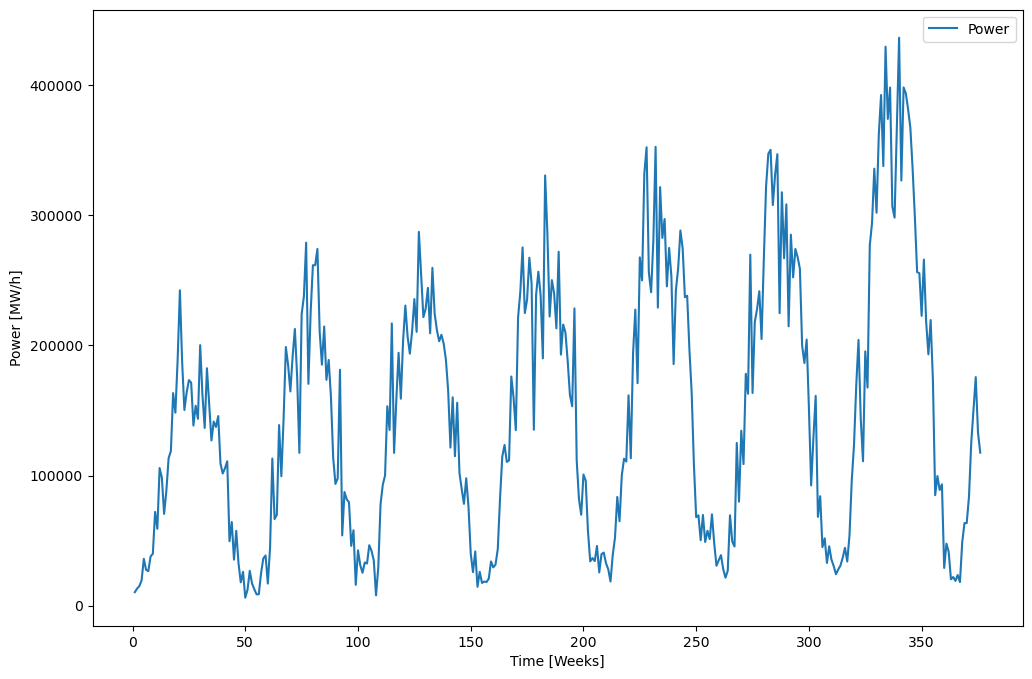

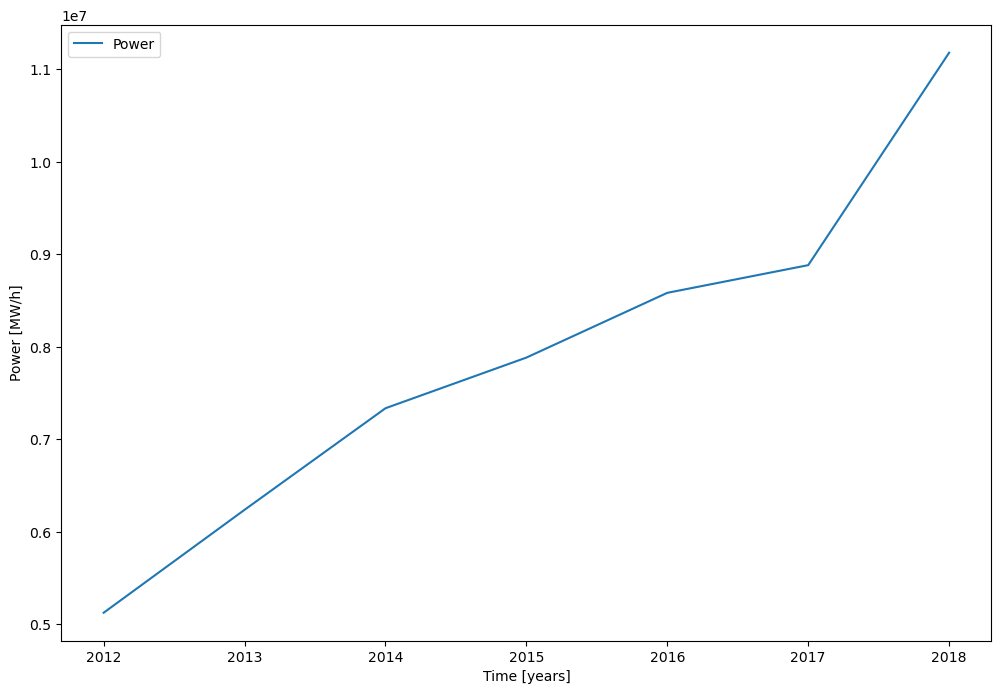

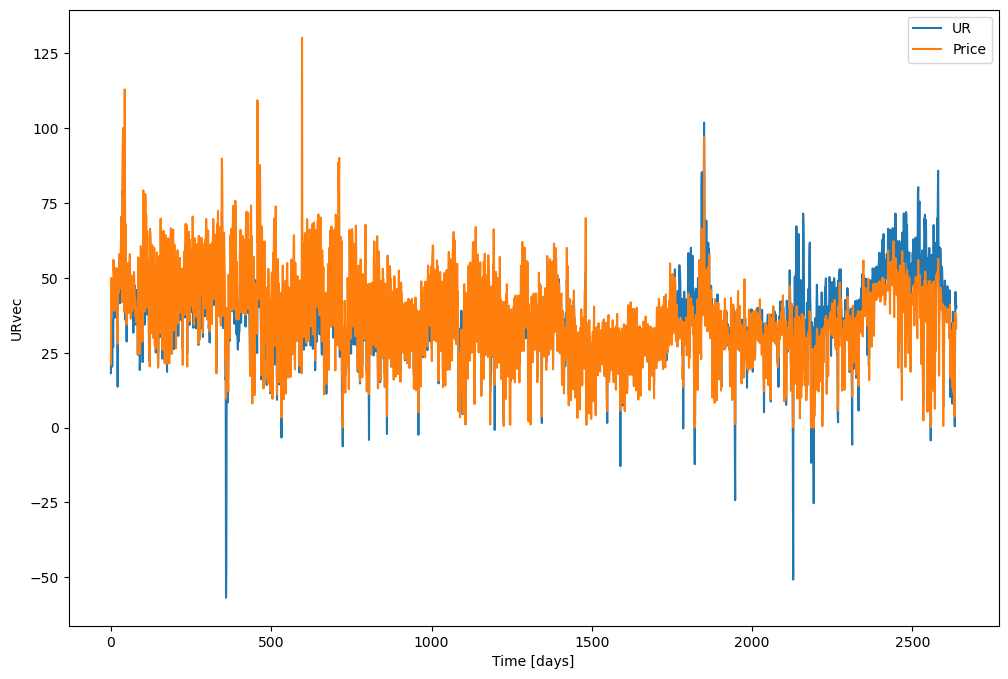

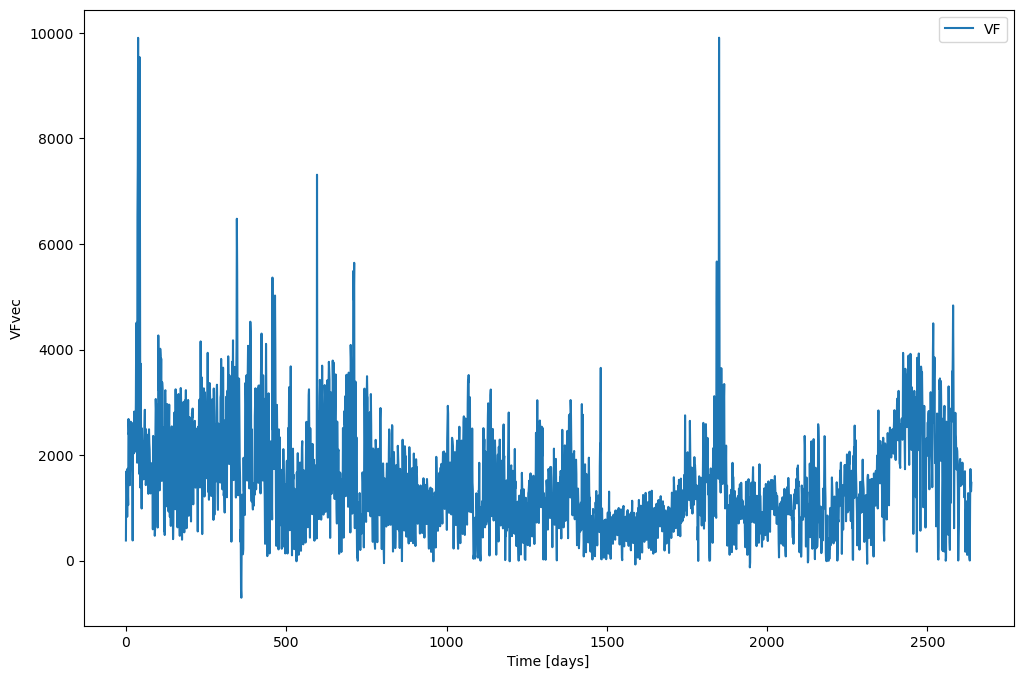

In [75]:
# This cell plots Power, Unite Revenue and Value Factor

#Number of days in averaged vector (7 - average over weeks, 30 - approximate averaging over months)
avDays = 7
numWeeks = int(len(PowerVec)/avDays)
Weeks = np.arange(1,numWeeks+1)
PowerVecWeeks = np.zeros([numWeeks])
for i in range(numWeeks):
    PowerVecWeeks[i] = np.sum(PowerVec[avDays*i:avDays*(i+1)])
    

plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
#minimum of the Power corresponds to the maximum of the Price
ax.plot(Weeks,PowerVecWeeks)
ax.legend(['Power'])
plt.xlabel('Time [Weeks]')
plt.ylabel(('Power [MW/h]'))
plt.show()

plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
#minimum of the Power corresponds to the maximum of the Price
ax.plot(years_num,PowerVecYears)
ax.legend(['Power'])
plt.xlabel('Time [years]')
plt.ylabel(('Power [MW/h]'))
plt.show()
plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
#minimum of the Power corresponds to the maximum of the Price
ax.plot(range(len(PriceVec)),PriceVec)
ax.plot(range(len(URvec)),URvec)

ax.legend(['UR','Price'])
plt.xlabel('Time [days]')
plt.ylabel(('URvec'))
plt.show()

plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
#Plot value factor and unite revenue
#ax.plot(range(len(URvec)),URvec/np.max(URvec))
ax.plot(range(len(VFvec)),VFvec)

ax.legend(['VF'])
plt.xlabel('Time [days]')
plt.ylabel(('VFvec'))
plt.show()

In [67]:
# This cell finds the trend in data using polynomial fitting with polynomial degree = 3
# and uses ARIMA for predicting stationary part of the data

# Load/split your data you want to predict
# auto ARIMA is described at https://github.com/alkaline-ml/pmdarima
# You predict daily Profile Premium for long period
# Because data trend changed around 2017, long term prediction based on historical data before 2017
# is unreliable

# Use the values in vector you want to use for prediction

numYear = range(0,len(PowerVec))

#Number of days in averaged vector (7 - average over weeks, 30 - approximate averaging over months)
avDays = 30
numTime = int(len(PowerVec)/avDays)
Time = np.arange(1,numTime+1)
PowerVecTime = np.zeros([numTime])
for i in range(numTime):
    PowerVecTime[i] = np.sum(PowerVec[avDays*i:avDays*(i+1)])

numYearAvg = range(int(numYear[0]/avDays),int(numYear[-1]/avDays))

# Extract trend using polinomial approximation
# Solar power has approximately Power_course = 1500-Weeks/10 trend
corse_trend = np.poly1d(np.polyfit(Days, PowerVec, 3))

corse_trend_years = np.poly1d(np.polyfit(years_num, PowerVecYears, 3))

# Vector you want to predict
# Here, Data minus coarse trend gives you stationary data

#TargetVec = PowerVecWeeks[numYearAvg]-avDays*corse_trend(avDays*Weeks)
TargetVec = PowerVecTime[numYearAvg]

# Define how many weeks you want to use for training data
train_Time = int(0.7*len(TargetVec))

# Here, you split your data into trained (train) and test (test) data sets
train, test = train_test_split(TargetVec, train_size = train_Time)

# Periodicity of your data
# 52 weeks correspond to 1 year periodicity, 4 weeks - monthly periodicity
# this parameter strongly affects the prediction

Periodicity = 12

# Fit your model using train data
model = pm.auto_arima(train, seasonal=True, m = Periodicity)

# make your forecasts
forecasts = model.predict(int(2*test.shape[0]))  # predict N steps into the future

time_forecasts = np.arange(Time[train_Time],Time[train_Time]+(Time[1]-Time[0])*forecasts.shape[0],Time[1]-Time[0])


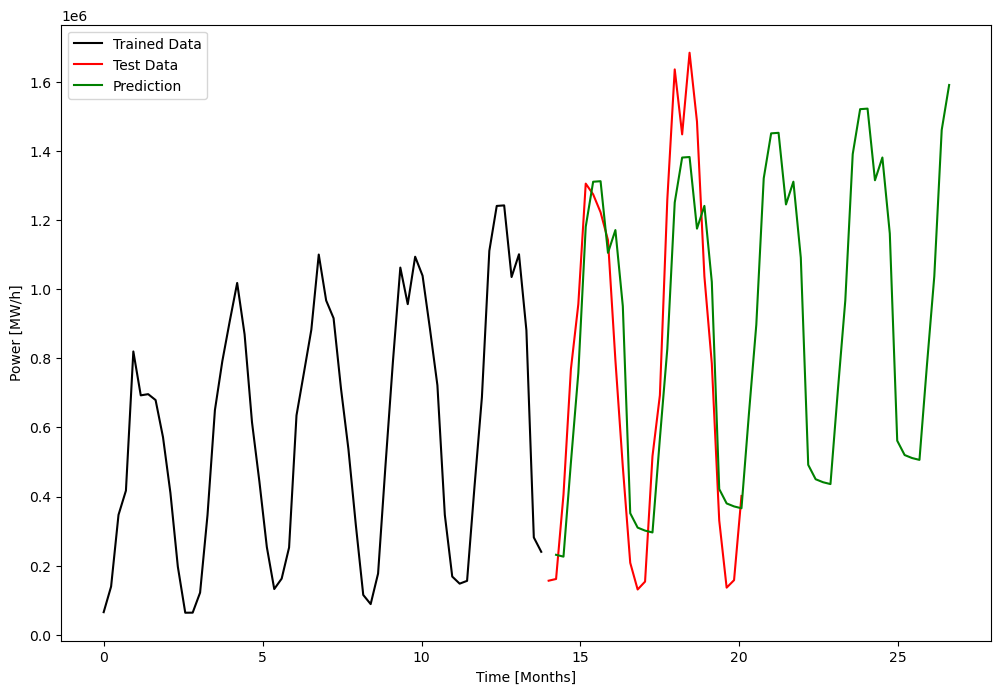

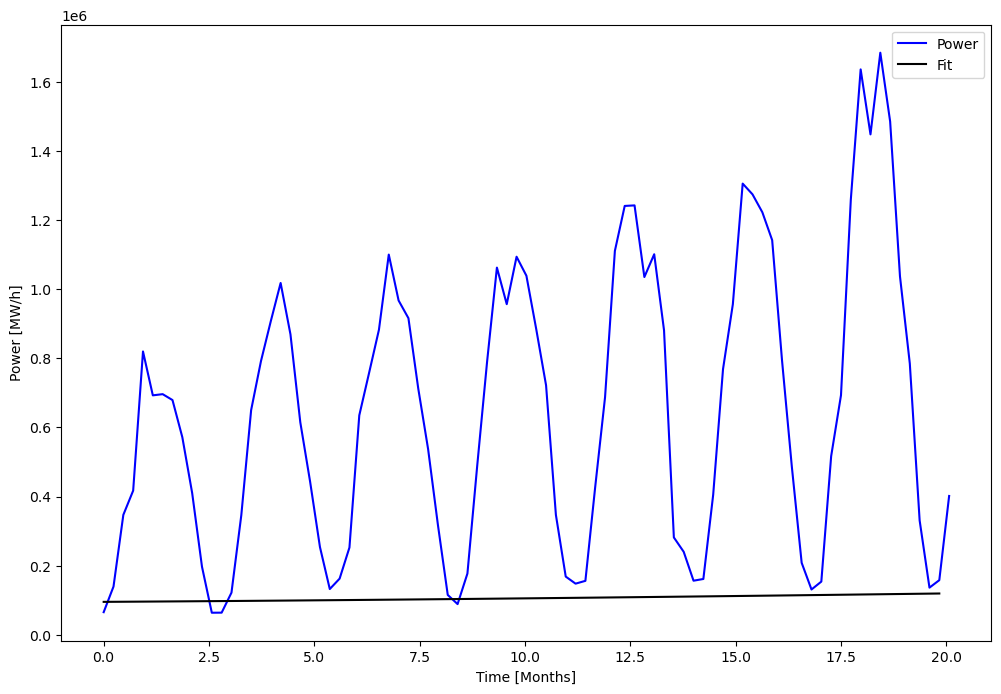

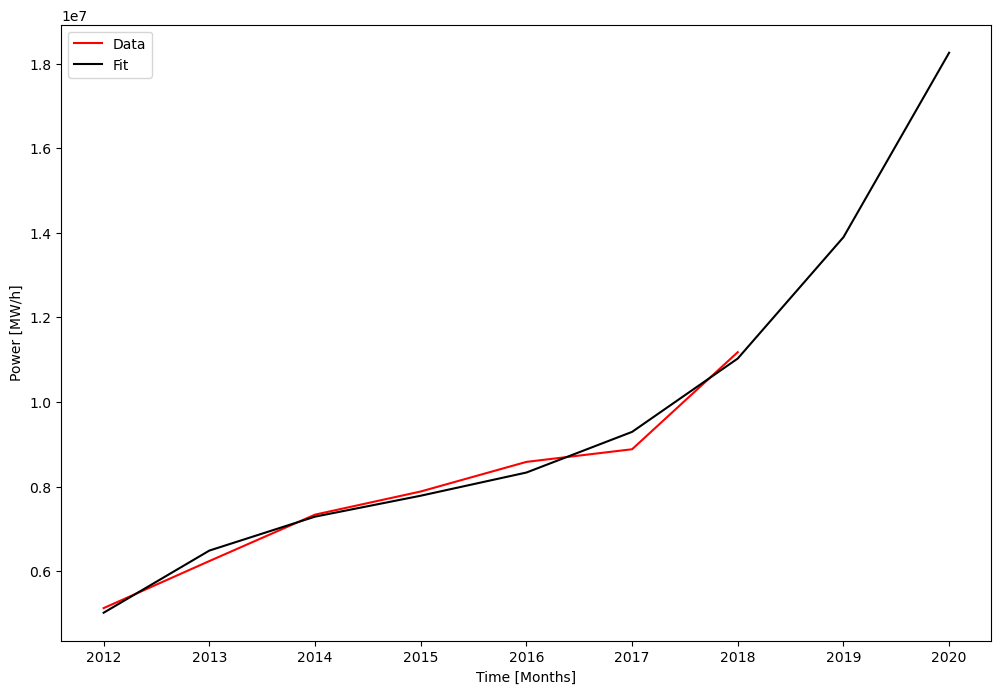

In [76]:
Time = np.arange(TargetVec.shape[0])

# Fit results
# Coarse trend
Time_Fit = np.arange(Time[0],int(1.0*Time[-1]))

# Visualize the forecasts (black=train, green=forecasts)
# Due to chaotic variations here is no obvious periodicity
# Therefore, ARIMA predict data by constant close to 0
# Power is mainly defined by the coarse trend

plt.figure(figsize = (12,8))
plt.plot(Time[:train_Time]*avDays/30, train, c='black')
plt.plot(Time[train_Time:]*avDays/30, TargetVec[train_Time:], c='red')
plt.plot(time_forecasts*avDays/30, forecasts, c='green')
plt.legend(('Trained Data','Test Data','Prediction'))
plt.xlabel('Time [Months]')
plt.ylabel('Power [MW/h]')
plt.show()

plt.figure(figsize = (12,8))
plt.plot(Time*avDays/30, PowerVecTime, c='blue')
plt.plot(Time_Fit*avDays/30, avDays*corse_trend(avDays*Time_Fit), c='black')
plt.legend(('Power','Fit'))
plt.xlabel('Time [Months]')
plt.ylabel('Power [MW/h]')
plt.show()

years_num_fit = np.arange(years_num[0],years_num[-1]+3)
# Coarse trend (years)
plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
#minimum of the Power corresponds to the maximum of the Price
ax.plot(years_num,PowerVecYears, c='red')
ax.plot(years_num_fit, corse_trend_years(years_num_fit), c='black')
ax.legend(['Power'])
ax.legend(['Data','Fit'])
plt.xlabel('Time [Months]')
plt.ylabel(('Power [MW/h]'))
plt.show()

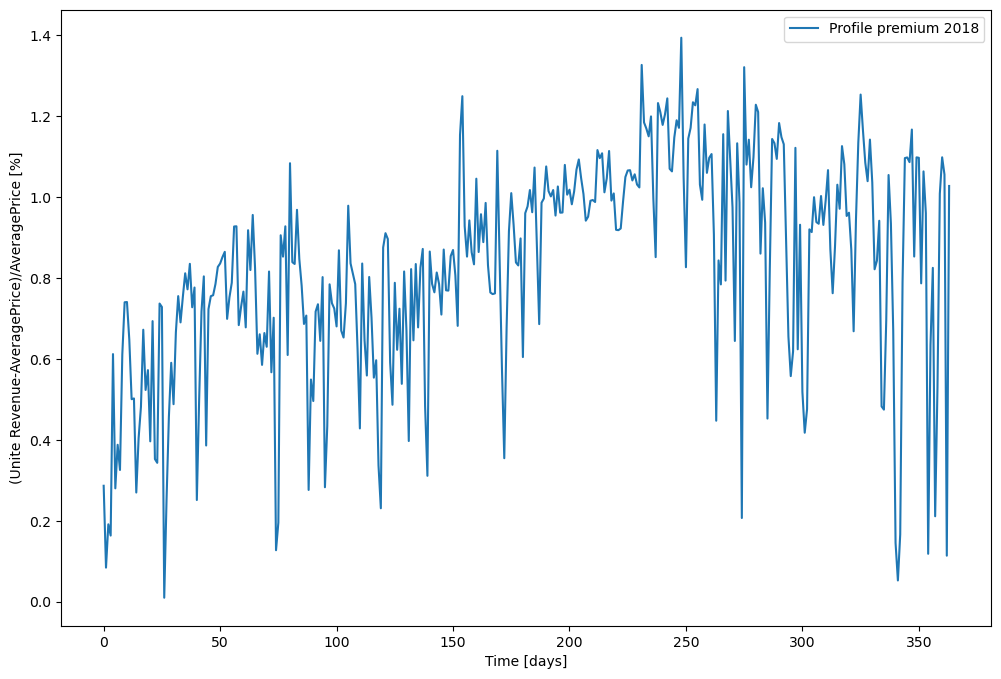

Profile Premium for 1 year is obtained in analogy with the weighted average used for daily UR factor
-0.5569010578271285
Profile premium for 1 year is obtained by calculating the total UR over year with hourly Power and Price
-10.593244543873478


In [53]:
#Here, we calculate Profile premium for different days within a single year

#minimum of the Power corresponds to the maximum of the Price
#ax.plot(range(len(URvec[1462:1827])),100*(URvec[1462:1827] - np.mean(PriceVec[1462:1827]))/np.mean(PriceVec[1462:1827]))

#German

# index 1 to 366 - 2012 
# 367 to 731 - 2013
# 732 to 1096 -2014
# 1097 to 1461 - 2015
# 1462 to 1827 - 2016
# 1828 to 2192 - 2017
# 2193 to 2557 - 2018
# 2558 to 2922 - 2019
# 2923 to 3288 - 2020

#2019 year - 1462 to 1826

#Use shift to navigate between years


shift = 0
ind1 = 2193
ind2 = 2557
numYear = range(ind1+shift,ind2+shift)
numYearH = range(24*(ind1+shift),24*(ind2+shift))
numYearPrice = range(ind1+shift,ind2+shift)


#ax.plot(range(len(URvec[1462:1827+365])),100*(URvec[1462:1827+365] - np.mean(PriceVec[1462:1827]))/np.mean(PriceVec[1462:1827]))
#UR factor from 2018 to 2020 and average price for 2018
#ax.plot(range(len(URvec[1462-365:1827+365])),100*(URvec[1462-365:1827+365] - np.mean(PriceVec[1462-365:1827-365]))/np.mean(PriceVec[1462-365:1827-365]))
plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
#ax.plot(range(len(URvec[numYear])),100*(URvec[numYear] - np.mean(PriceVec[numYear]))/np.mean(PriceVec[numYear]))
ax.plot(range(len(URvec[numYear])),(URvec[numYear])/np.mean(PriceVec[numYear]))

ax.legend(['Profile premium 2018'])
plt.xlabel('Time [days]')
plt.ylabel(('(Unite Revenue-AveragePrice)/AveragePrice [%]'))
plt.show()

#Calculate UR for 1 year using analogy for 1 day
URyear = np.sum(np.multiply(PriceVec[numYear],PowerVec[numYear]))/np.sum(PowerVec[numYear])
dUR1 = 100*(URyear - np.mean(PriceVec[numYearPrice]))/np.mean(PriceVec[numYearPrice])
#UR for 1 year is obtained by averaging dayly UR factor
dUR2 = 100*(np.mean(URvec[numYear]) - np.mean(PriceVec[numYearPrice]))/np.mean(PriceVec[numYearPrice])
#UR for 1 year is obtained by averaging dayly UR factor
URyearH = np.sum(np.multiply(PriceVecH[numYearH],PowerVecH[numYearH]))/np.sum(PowerVecH[numYearH])
dUR3 = 100*(URyearH - np.mean(PriceVec[numYearPrice]))/np.mean(PriceVec[numYearPrice])
print('Profile Premium for 1 year is obtained in analogy with the weighted average used for daily UR factor')
print(dUR1)
#print('UR for 1 year is obtained by averaging daily UR factors')
#print(dUR2)
print('Profile premium for 1 year is obtained by calculating the total UR over year with hourly Power and Price')
print(dUR3)

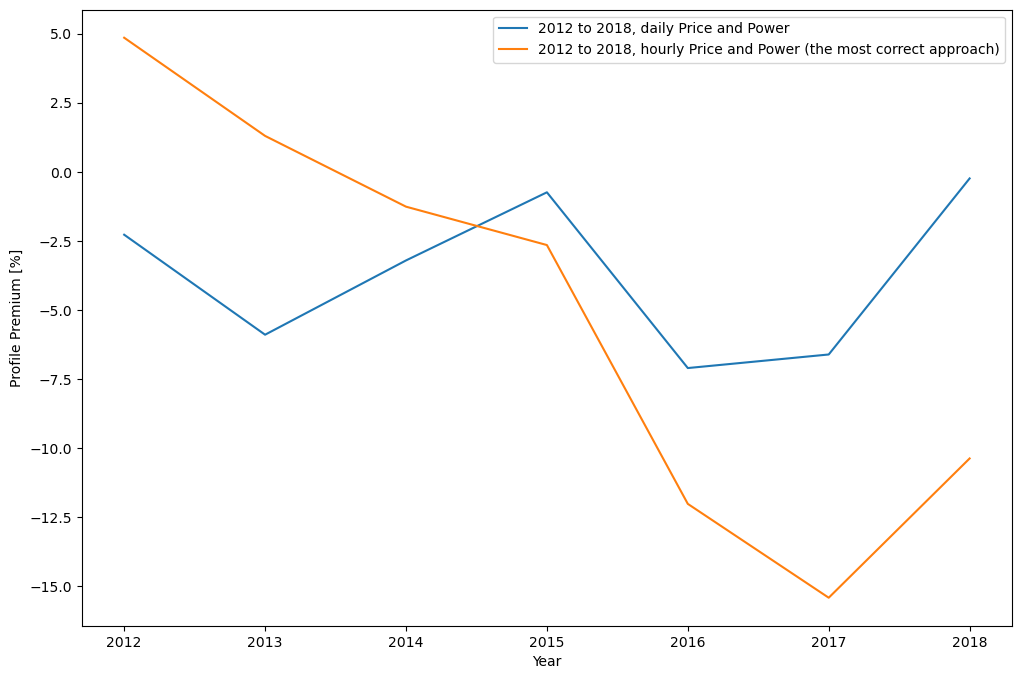

In [77]:
#Here, we calculate Profile premium for different years

#German

# index 1 to 366 - 2012 
# 367 to 731 - 2013
# 732 to 1096 -2014
# 1097 to 1461 - 2015
# 1462 to 1827 - 2016
# 1828 to 2192 - 2017
# 2193 to 2557 - 2018
# 2558 to 2922 - 2019
# 2923 to 3288 - 2020

#YearBounds = [0, 366, 731, 1096,1461, 1827, 2192, 2557, 2922, 3287]
#YearsUsed = [2012,2013,2014,2015,2016,2017,2018,2019,2020]

YearBounds = [0, 366, 731, 1096,1461, 1827, 2192, 2557]
YearsUsed = [2012,2013,2014,2015,2016,2017,2018]

PP_Year = np.zeros(len(YearBounds)-1)
PP_YearH = np.zeros(len(YearBounds)-1)
for num in range(0,len(YearBounds)-1):
    numYear = range(YearBounds[num],YearBounds[num+1])
    
    #UR for 1 year is obtained by averaging dayly Power and Price
    # Price_i, Power_i, PP = Sum(Price_i*Power_i)/(Sum(Power_i) * <Price>_year) - 1
    # i denotes day, Price_i - average dayly price, Power_i - dayly power, <Price>_year - average price over year
    # Sum(Power_i) - total Power over year
    
    URyear = np.sum(np.multiply(PriceVec[numYear],PowerVec[numYear]))/np.sum(PowerVec[numYear])
    PP_Year[num] = 100*(URyear - np.mean(PriceVec[numYear]))/np.mean(PriceVec[numYear])
    numYearH = range((YearBounds[num])*24,YearBounds[num+1]*24)
    
    #UR for 1 year is obtained by averaging hourly Power and Price
    # Price_i, Power_i, PP = Sum(Price_i*Power_i)/(Sum(Power_i)*<Price>_year) - 1
    # i denotes hour, Price_i - hourly price, Power_i - hourly power, <Price>_year - average price over year
    # Sum(Power_i) - total Power over year
    
    URyearH = np.sum(np.multiply(PriceVecH[numYearH],PowerVecH[numYearH]))/np.sum(PowerVecH[numYearH])
    PP_YearH[num] = 100*(URyearH - np.mean(PriceVec[numYear]))/np.mean(PriceVec[numYear])

plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1)
ax.plot(YearsUsed,PP_Year)
ax.plot(YearsUsed,PP_YearH)

ax.legend(['2012 to 2018, daily Price and Power', '2012 to 2018, hourly Price and Power (the most correct approach)'])
plt.xlabel('Year')
plt.ylabel(('Profile Premium [%]'))
plt.show()

In [54]:
# A few step prediction for daily Profile Premium
# You predict for short period that you define by step_future (number of steps in the future)
# step_future defines the number in the future

numYear = range(1827,2500)

TargetVec = 100*(URvec[numYear] - np.mean(PriceVec[numYear]))/np.mean(PriceVec[numYear])
days = np.arange(TargetVec.shape[0])
train_days = 450
train, test = train_test_split(TargetVec, train_size = train_days)

kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

# seeded from the model we've already fit

Periodicity = 7

model_auto = pm.auto_arima(train,d=n_diffs,seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True, m = Periodicity)

step_future = 30
num_future = int(len(test)/step_future)
num_future_days = int(num_future*step_future)


def forecast_one_step():
    fc, conf_int = model_auto.predict(n_periods=step_future, return_conf_int=True)
    return (
        fc.tolist()[:],
        np.asarray(conf_int).tolist()[:])
        #fc.tolist()[0],
        #np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []


#for new_ob in test:
for ind in range(0,num_future):
    fc, conf = forecast_one_step()
    for f in fc:
        forecasts.append(f)
    for c in conf:
        confidence_intervals.append(c)

    # Updates the existing model with a small number of MLE steps
    model_auto.update(test[ind*step_future:(ind+1)*step_future:1])

print(f"Mean squared error: {mean_squared_error(test[0:len(forecasts)], forecasts)}")
print(f"SMAPE: {smape(test[0:len(forecasts)], forecasts)}")

Estimated differencing term: 1
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=4254.796, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=4191.796, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=4162.328, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=4252.812, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=4190.081, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=4156.576, Time=0.82 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=4224.374, Time=0.46 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=4102.250, Time=1.13 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=4104.378, Time=0.94 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=3.01 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=4040.273, Time=2.38 sec
 ARIMA(1,1,1)(1,0,0)[7

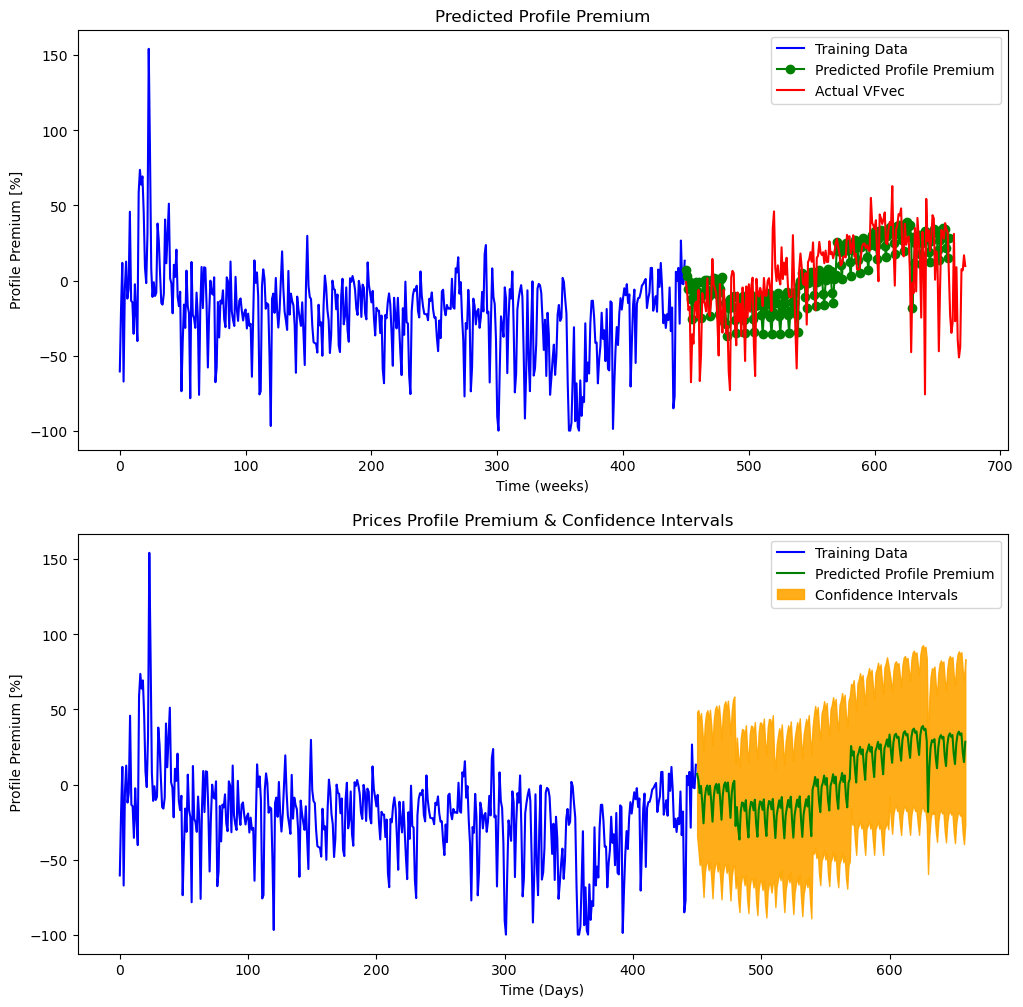

In [56]:
# Uses model from the previous cell

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(days[:train_days:],train, color='blue', label='Training Data')
axes[0].plot(days[train_days:train_days+num_future_days:], forecasts, color='green', marker='o',
             label='Predicted Profile Premium')

axes[0].plot(days[train_days::], test, color='red', label='Actual VFvec')
axes[0].set_title('Predicted Profile Premium')
axes[0].set_xlabel('Time (weeks)')
axes[0].set_ylabel('Profile Premium [%]')

#axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(days[:train_days:],train, color='blue', label='Training Data')
axes[1].plot(days[train_days:train_days+num_future_days:], forecasts, color='green',
             label='Predicted Profile Premium')

axes[1].set_title('Prices Profile Premium & Confidence Intervals')
axes[1].set_xlabel('Time (Days)')
axes[1].set_ylabel(' Profile Premium [%]')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(days[train_days:train_days+num_future_days:],
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")
axes[1].legend()

#PP = (UR-Price)/Price = UR/Price - 1